# Step 0: Defining Model Class

In [1]:
# Basics
import pandas as pd
import numpy as np

#Plotting
from matplotlib import pyplot as plt
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
plt.style.use('ggplot')

# Warnings
import warnings
warnings.filterwarnings('ignore')

#Auto ARIMA
try:
    from pmdarima.arima import auto_arima
except:
    ! pip install pmdarima
    from pmdarima.arima import auto_arima

# Import statsmodels api
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Tools for saving the model
import pickle
from bz2 import BZ2File

class Model(object):
    
    def __init__(self, test_size=48, predict_size=60):
        self.model_dictionary = {}
        self.test_size = test_size
        self.predict_size = predict_size
        
    def build_model(self):
        try:
            with BZ2File('modelArchive.bz2', 'rb') as file:
                self.model_dictionary = pickle.load(file)
        except:
            print("File not found. Building model.")
            zip_codes = self.model_dictionary.keys()
            N = len(zip_codes)
            for ind, zip_code in enumerate(zip_codes):
                self.fit(zip_code, trace=False)
                self.predict(zip_code)
                self.forecast(zip_code)
                print(f'Finished processing {ind+1} out of {N} zip codes.')
            with BZ2File('modelArchive.bz2', 'wb') as file:
                pickle.dump(self.model_dictionary, file)
    
    # Load data from data frame
    def load_data(self, df):
        self._make_datetime_index(df)
        for ind in df.index.values:
            row = df.loc[ind]
            zip_code = self._get_zip_code(row)
            row_dict = self._make_row_dict(row)
            self.model_dictionary[zip_code] = row_dict
    
    def _make_datetime_index(self, df):
        string_index = df.columns.values[8:]
        self.datetime_index = pd.to_datetime(string_index)
            
    def _get_zip_code(self, row):
        return row['RegionName']
            
    def _make_row_dict(self, row):
        row_dict = row.iloc[1:8].to_dict()
        time_series = row.iloc[8:]
        df = self._make_time_series_df(time_series)
        df = df.fillna(df.bfill())
        row_dict['TimeSeries'] = df
        return row_dict
      
    def _make_time_series_df(self, time_series):
        time_series.index = self.datetime_index
        df = pd.DataFrame(time_series, dtype=float)
        df.columns = ['MedianSales']
        return df
    
    def get_time_series(self, zip_code):
        return self.model_dictionary[zip_code]['TimeSeries']
    
    def get_city_name(self, zip_code):
        return self.model_dictionary[zip_code]['City']
    
    def get_state_abbreviation(self, zip_code):
        return self.model_dictionary[zip_code]['State']
    
    # Train Test Split    
    def get_train_test_split(self, zip_code):
        time_series_df = self.get_time_series(zip_code)
        train = time_series_df[:-self.test_size]
        test = time_series_df[-self.test_size:]
        return train, test
    
    # Plotting
    def time_series_plot(self, zip_code, show_prediction=True, show_forecast=True):
        fig, ax = plt.subplots(figsize=(8, 5));
        self._time_series_plot_train_test_ax(zip_code, ax)
        legend_labels = ['Train', 'Test']
        if show_prediction:
            self._time_series_plot_prediction_ax(zip_code, ax)
            legend_labels.append('Prediction')
        if show_forecast:
            self._time_series_plot_forcast_ax(zip_code, ax)
            legend_labels.append('Forecast')
        self._time_series_plot_annotate(zip_code, ax, legend_labels)
        return fig
    
    def _time_series_plot_train_test_ax(self, zip_code, ax):
        train, test = self.get_train_test_split(zip_code)
        ax.plot(train);
        ax.plot(test);
        
    def _time_series_plot_prediction_ax(self, zip_code, ax):
        prediction = self.predict(zip_code)
        ax.plot(prediction['mean'])
        ax.fill_between(
            prediction.index,
            prediction['mean_ci_lower'],
            prediction['mean_ci_upper'],
            color = 'g',
            alpha = 0.5
        )
    def _time_series_plot_forcast_ax(self, zip_code, ax):
        forecast = self.forecast(zip_code)
        ax.plot(forecast['mean'])
        ax.fill_between(
            forecast.index,
            forecast['mean_ci_lower'],
            forecast['mean_ci_upper'],
            color = 'g',
            alpha = 0.5
        )
        
        
    def _time_series_plot_annotate(self, zip_code, ax, legend_labels):
        city_name = self.get_city_name(zip_code)
        state_abbreviation = self.get_state_abbreviation(zip_code)
        ax.set_title(f'Median Sale Price {city_name}, {state_abbreviation} {zip_code}')
        ax.set_xlabel('Date')
        ax.set_ylabel('Price')
        ax.legend(legend_labels);
        
    def acf_plot(self, zip_code):
        city_name = self.get_city_name(zip_code)
        state_abbreviation = self.get_state_abbreviation(zip_code)
        train, test = self.get_train_test_split(zip_code)
        fig, ax = plt.subplots(figsize=(8,5));
        plot_acf(
            x=train, 
            ax=ax, 
            lags=100,
            title=f'Autocorrelation for {city_name}, {state_abbreviation} {zip_code}'
        );
        return fig
    
    def pacf_plot(self, zip_code):
        city_name = self.get_city_name(zip_code)
        state_abbreviation = self.get_state_abbreviation(zip_code)
        train, test = self.get_train_test_split(zip_code)
        fig, ax = plt.subplots(figsize=(8,5));
        plot_pacf(
            x=train, 
            ax=ax, 
            lags=100,
            title=f'Partial Autocorrelation for {city_name}, {state_abbreviation} {zip_code}'
        );
        return fig
    
    # Model Selection
    def fit(self, zip_code, trace=True):
        try:
            best_model = self.model_dictionary[zip_code]['BestModel']
        except:
            y = self.get_time_series(zip_code)
            model = auto_arima(
                y = y,
                X=None,
                start_p=0,
                d=1,
                start_q=0,
                max_p=2,
                max_d=2,
                max_q=2,
                start_P=0,
                D=1,
                start_Q=0,
                max_P=2,
                max_D=2,
                max_Q=2,
                max_order=None,
                m=12,
                seasonal=True,
                stationary=False,
                information_criterion='oob',
                alpha=0.05,
                test='kpss',
                seasonal_test='OCSB',
                stepwise=True,            
                suppress_warnings=True,
                error_action='warn',
                trace=trace,
                out_of_sample_size= self.test_size,
                scoring='mse'
            )
            order = model.order
            seasonal_order = model.seasonal_order
            trend = model.trend
            best_model = SARIMAX(
                endog=y,
                order=order,
                seasonal_order=seasonal_order,
                trend=trend
            ).fit()
            self.model_dictionary[zip_code]['BestModel'] = best_model
        return best_model
    
    # Model Validation
    def predict(self, zip_code):
        try:
            prediction = self.model_dictionary[zip_code]['Prediction']
        except:
            model = self.fit(zip_code)
            prediction = model.get_prediction().summary_frame()
            self.model_dictionary[zip_code]['Prediction'] = prediction
        return prediction
    
    def plot_diagnostics(self, zip_code):
        best_model = self.fit(zip_code)
        city = self.get_city_name(zip_code)
        state = self.get_state_abbreviation(zip_code)
        fig = best_model.plot_diagnostics(figsize=(16, 10));
        fig.suptitle(f'Diagnostics for {city}, {state} {zip_code}', fontsize=16)
        return fig
    
    # Predict future prices
    def forecast(self, zip_code):
        try:
            forecast = self.model_dictionary[zip_code]['Forecast']
        except:
            model = self.fit(zip_code)
            forecast = model.get_forecast(steps=self.predict_size).summary_frame()
            self.model_dictionary[zip_code]['Forecast'] = forecast
        return forecast
    
    # Compute ROI
    def compute_roi(self, zip_code):
        try:
            roi = self.model_dictionary[zip_code]['ROI']
        except:
            initial_price = self.get_time_series(zip_code)['MedianSales'][-1]
            final_price = self.forecast(zip_code)['mean'][-1]
            roi = (final_price-initial_price)/initial_price
            self.model_dictionary[zip_code]['ROI'] = roi
        return roi


# Step 1: Import the Data
Our main data set is stored in the `zillow_data.csv` spreadsheet. We load the CSV file as a data frame below.

In [ ]:
df = pd.read_csv('../data/ZHVI.csv.gz', index_col='RegionID', compression='gzip')
print(df.shape)
df.head()

We will restrict our attention to the city of Baltimore, so we filter the data below.

In [ ]:
df = df.query("City == 'Baltimore' and State == 'MD'")
print(df.shape)
df.head()

# Step 2: Instantiate the Model and Load in the Data
Below we instantiate a Model object and load our selected data into the object.

In [2]:
model = Model()

In [3]:
model.build_model()

# Step 3: EDA and Visualization
Below we display a time series plot, ACF plot, and PACF plot for the zip code 21215. The class methods used below will work for any zip code in our model.

In [4]:
zip_code = 21215

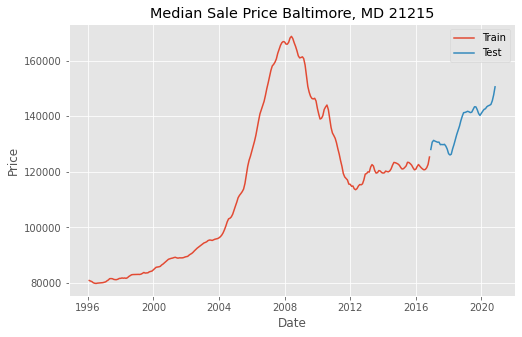

In [5]:
model.time_series_plot(zip_code, show_prediction=False, show_forecast=False);

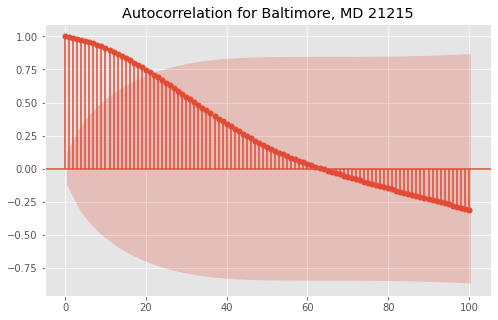

In [6]:
model.acf_plot(zip_code);

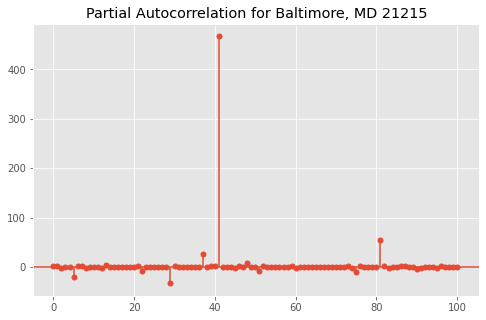

In [7]:
model.pacf_plot(zip_code);

# Step 4: ARIMA Modeling
Below we select the best ARIMA model for our example zip code.

In [8]:
best_model = model.fit(zip_code)

# Step 5: Model Validation
Below we make an in sample prediction using our best model, display the prediction with the actual data, and display diagnostic plots for the fit.

In [9]:
model.predict(zip_code)

MedianSales,mean,mean_se,mean_ci_lower,mean_ci_upper
1996-01-31,0.000000,2031.826214,-3982.306203,3982.306203
1996-02-29,88647.252076,1757.908990,85201.813767,92092.690384
1996-03-31,83386.305208,1753.103188,79950.286098,86822.324318
1996-04-30,80729.233315,1752.652332,77294.097866,84164.368764
1996-05-31,80086.139254,1752.646669,76651.014904,83521.263603
...,...,...,...,...
2020-06-30,144688.470326,1396.491729,141951.396833,147425.543820
2020-07-31,144733.104654,1396.491729,141996.031161,147470.178148
2020-08-31,144221.334534,1396.491729,141484.261040,146958.408028
2020-09-30,145105.847545,1396.491729,142368.774051,147842.921039


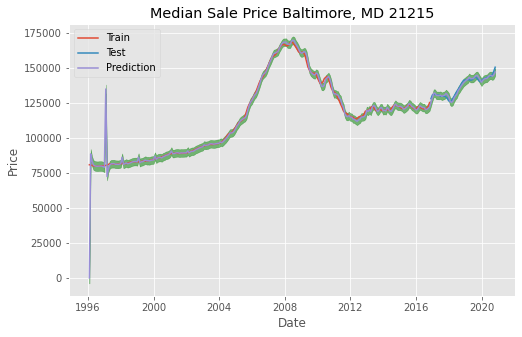

In [10]:
model.time_series_plot(zip_code, show_forecast=False);

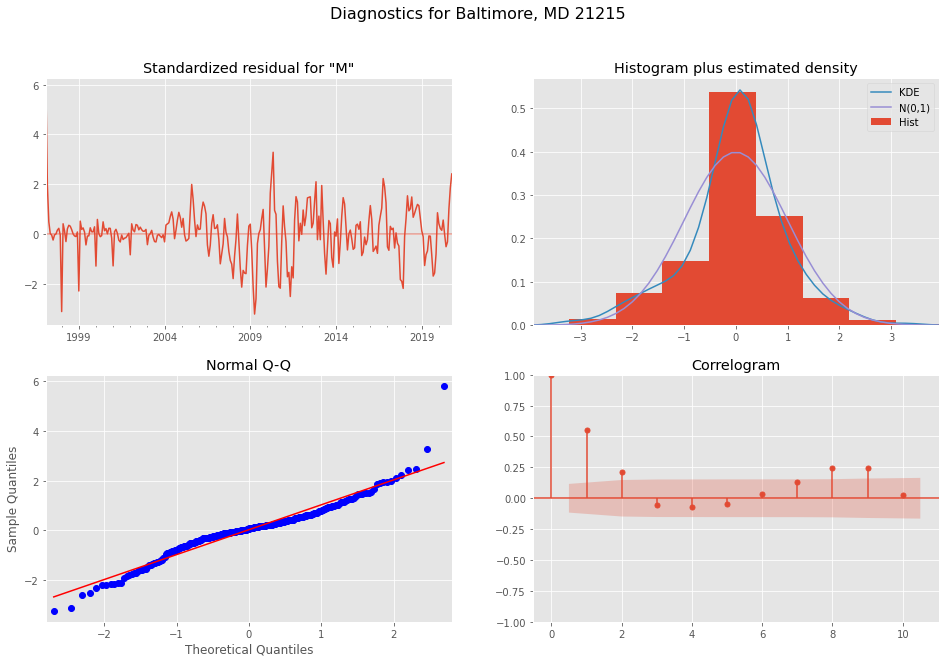

In [11]:
model.plot_diagnostics(zip_code);

# Step 6: Making a Forecast
Below we forecast into the future, make a final time series plot which includes our forecast, and compute our expected return on investment for the example zip code.

In [12]:
model.forecast(zip_code)

MedianSales,mean,mean_se,mean_ci_lower,mean_ci_upper
2020-11-30,150976.629993,1396.491729,148239.556499,153713.703486
2020-12-31,151982.546674,2155.603520,147757.641410,156207.451939
2021-01-31,152731.729666,2784.971885,147273.285073,158190.174259
2021-02-28,153309.466732,3315.175677,146811.841803,159807.091660
2021-03-31,153560.236195,3777.757069,146155.968398,160964.503993
2021-04-30,154161.710668,4191.405056,145946.707713,162376.713623
2021-05-31,154524.740046,4568.330255,145570.977278,163478.502814
2021-06-30,154784.601652,4916.625530,145148.192688,164421.010615
2021-07-31,155158.114744,5241.887752,144884.203540,165432.025948
2021-08-31,156300.717832,5548.132723,145426.577513,167174.858150


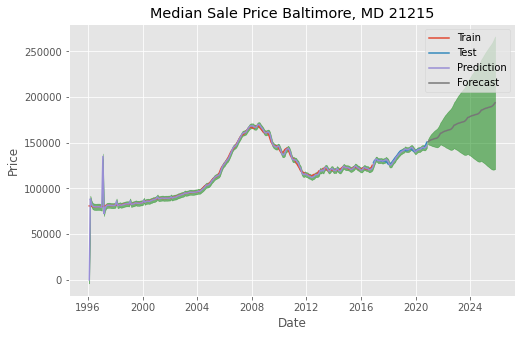

In [13]:
model.time_series_plot(zip_code);

In [14]:
model.compute_roi(zip_code)

0.2865403592547181

# Step 7: Building the Model

In [15]:
model.build_model()